# PyOpenCAP and OpenMolcas
In this tutorial we, post process results from an XMS-CASPT2 calculation from OpenMolcas to perform CAP/XMS-CASPT2 calculations on the ${}^2\Pi_g$ shape resonance of $N_2^-$.

In [1]:
import pyopencap
import numpy as np
from pandas import DataFrame

# Part 1: Post-processing results to compute CAP matrix using pyopencap

## Constructing the system object
The System object of PyOpenCAP contains the geometry and basis set information, as well as the overlap matrix. The constructor exposed to Python takes in a Python dictionary as an argument, with key/value pairs which mimic the input file format of the command line version. There are three equivalent ways of specifying the geometry and basis set: rassi_h5, molden, and inline. The "inline" option requires specifying a path to a basis set formatted in Psi4 style, which can be downloaded from the basis set exchange. Here, we’ll use the rassi_h5 file.

In [2]:
RASSI_FILE = "ref_outputs/xms.rassi.h5"
OUTPUT_FILE = "ref_outputs/xms.out"
sys_dict_inline = {"geometry":'''N        0.0     0.0     0.548757
                    N        0.0     0.0     -0.548757
                    X       0.0     0.0     0.0''',  # ghost atoms are indicated with X
        "basis_file":"basis.bas",
        "molecule": "inline"
}
sys_dict_molden = {"molecule": "molden","basis_file": "file.molden"}
sys_dict_rassi = {"molecule": "molcas_rassi","basis_file": RASSI_FILE}
s = pyopencap.System(sys_dict_rassi)
smat = s.get_overlap_mat()
np.shape(smat)

(119, 119)

## Constructing the CAP object
The CAP matrix is computed by the “CAP” object. The constructor for the CAP object requires a System object, a dictionary containing the CAP parameters, and the number of states (10 in this case). We can compute and retrieve the CAP matrix in AO basis right now if we want to, but we need the 1RDMs and 1TDMs to perform the subspace projection. The returned CAP matrix in AO basis has a -1 prefactor.

In [3]:
cap_dict = {"cap_type": "voronoi",
            "r_cut": "3.00"}
pc = pyopencap.CAP(s,cap_dict,10)
pc.compute_ao_cap()
W_AO = pc.get_ao_cap()

Integration time:3.067045


## Parsing electronic structure data from file

The “read_data” function of the CAP object can read in the effective Hamiltonian and densities in one-shot when passed a Python dictionary with the right keywords. For now, we’ll retrieve the effective Hamiltonian and store it as h0 for later use.

In [4]:
es_dict = { "package": "openmolcas",
       "method" : "xms-caspt2",
       "molcas_output":OUTPUT_FILE,
       "rassi_h5":RASSI_FILE}
pc.read_data(es_dict)
h0 = pc.get_H()
pc.compute_projected_cap()

Successfully read in zeroth order Hamiltonian from file:ref_outputs/xms.out
Reading densities from file:ref_outputs/xms.rassi.h5
Done.
Verified overlap matrix.


Once all of the densities are loaded, the CAP matrix is computed using the “compute_projected_cap” function. The matrix can be retrieved using the “get_projected_cap” function. The returned CAP matrix has a -1 prefactor.

In [5]:
pc.compute_projected_cap()
W = pc.get_projected_cap()

# Part 2: Eigenvalue trajectories using pyopencap.analysis submodule

Now that we have our H0 and W matrices in state basis, let's generate and analyze eigenvalue trajectories.

In [6]:
from pyopencap.analysis import CAPHamiltonian
import matplotlib.pyplot as plt

The CAPHamiltonian object handles is our main tool for analyzing trajectories. It is constructured using the matrices we obtained in Part 1, or with the pc object.

In [7]:
CAPH = CAPHamiltonian(H0=h0,W=W)
CAPH = CAPHamiltonian(pc=pc)

The run_trajectory function is used to generate eigenvalue trajectories. The CAP Hamiltonian is diagonalized over the specified range of cap strength values, and the results are stored.

In [8]:
eta_list = np.linspace(0,1500,101)
eta_list = np.around(eta_list * 1E-5,decimals=5)
CAPH.run_trajectory(eta_list)

We can track each eigenstate using the "track_state" function. One can track states using either eigenvector overlap ("overlap") or energy ("energy").

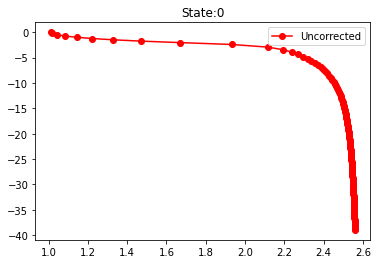

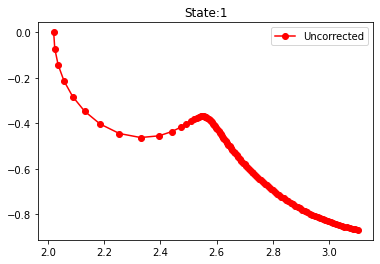

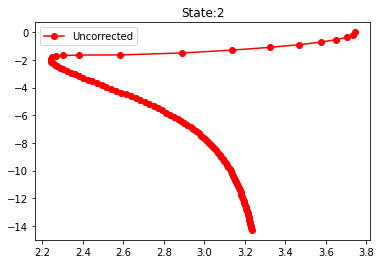

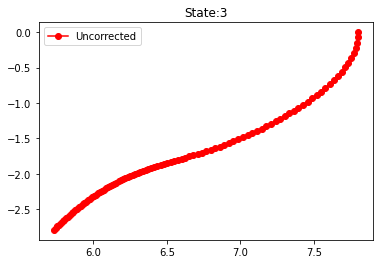

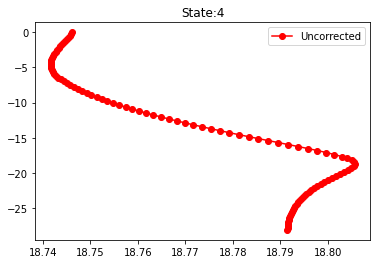

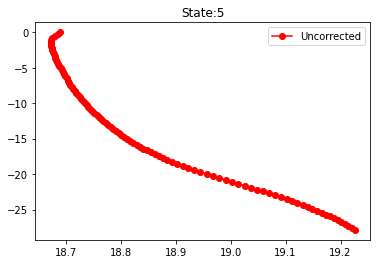

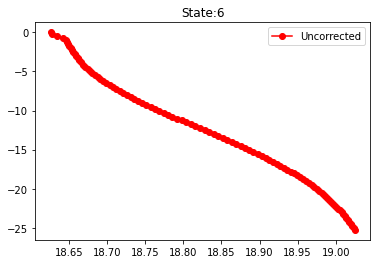

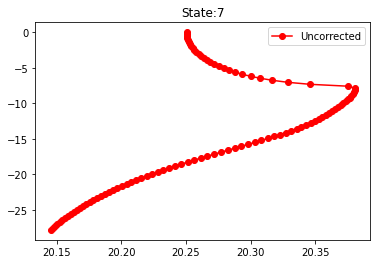

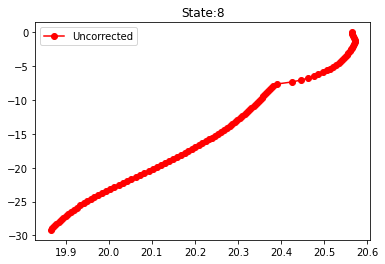

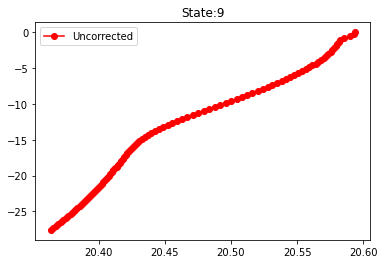

In [9]:
# CASPT2 energy for neutral w/ same orbitals
ref_energy = -109.35460366
for i in range(0,CAPH.nstates):
    traj = CAPH.track_state(i,tracking="overlap")
    uc_energies = traj.energies_ev(ref_energy=ref_energy)
    plt.plot(np.real(uc_energies),np.imag(uc_energies),'-ro',label="Uncorrected")
    plt.title("State:" + str(i))
    plt.legend()
    plt.show()

The 2nd (index 1) state is our resonance state, so let's retrieve it using "track_state", which returns an "EigenvalueTrajectory" object.

In [10]:
traj = CAPH.track_state(1,tracking="overlap")

The "EigenvalueTrajectory" object contains helpful functions for plotting, obtaining corrected trajectories, and for finding the optimal value of the CAP strength parameter for both uncorrected (red) and corrected (blue) trajectories.

Uncorrected:
(2.5535552795831826-0.36969119140511375j)
0.00285
Corrected:
(2.462760040100776-0.19013054160686368j)
0.00555


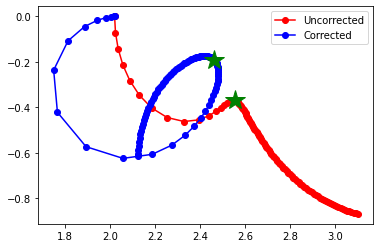

In [11]:
uc_energies = traj.energies_ev(ref_energy=ref_energy)
corr_energies = traj.energies_ev(ref_energy=ref_energy,corrected=True)
uc_energy, eta_opt = traj.find_eta_opt(start_idx=10)
uc_energy = (uc_energy-ref_energy)*27.2114
corr_energy, corr_eta_opt = traj.find_eta_opt(corrected=True,start_idx=10)
corr_energy = (corr_energy-ref_energy)*27.2114
print("Uncorrected:")
print(uc_energy)
print(eta_opt)
print("Corrected:")
print(corr_energy)
print(corr_eta_opt)
plt.plot(np.real(uc_energies),np.imag(uc_energies),'-ro',label="Uncorrected")
plt.plot(np.real(corr_energies),np.imag(corr_energies),'-bo',label="Corrected")
plt.plot(np.real(uc_energy),np.imag(uc_energy),'g*',markersize=20)
plt.plot(np.real(corr_energy),np.imag(corr_energy),'g*',markersize=20)
plt.legend()
plt.show()